# Explore Neural networks, regularization methods and SGD methods

The questions I am to answer are:
- how many neurons are ideal in hidden layer?
- deep and narrow vs shallow and wide networks
- differnet activation functions
- does batchnorm makes a difference?

### Setup

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
from sklearn.datasets import fetch_mldata
from torch.optim.lr_scheduler import StepLR
import pandas as pd

## Data Loading

In [2]:
ds_train = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
train_loader = torch.utils.data.DataLoader(ds_train,batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=32, shuffle=True)

## Logistic Regression Baseline

Same as from yesterday's excercise except we use the pytorch declarative api for it

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [4]:
d_in = 784

Train

In [73]:
def get_validation_error(model):
    model.eval()
    loss = 0.0
    correct = 0.0
    num = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        with torch.no_grad():
            a_out = model(inputs)
        _, yh = torch.max(a_out, 1)
        loss += criterion(a_out, labels).item() * labels.shape[0]
        correct += (yh == labels).sum().item()
        num += labels.shape[0]
    #print(f"Validation Loss: {loss/num} accuracy: {correct/num}")
    return loss/num, correct/num

In [74]:
def train(model, optimizer, criterion, epochs=10, lrs=None):
    val_loss, val_acc = [], []
    for e in range(epochs):
        #print(f"epoch: {e}")
        if lrs is not None: lrs.step()
        for inputs, labels in test_loader:
            model.train()
            inputs, labels = inputs.to('cuda'), labels.to('cuda') 

            optimizer.zero_grad()
            logits = model(inputs)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        vloss, vacc = get_validation_error(model)
        val_loss.append(vloss), val_acc.append(vacc)
    return pd.DataFrame({'loss': val_loss, 'acc': val_acc})
        

In [75]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(d_in, 10)
)

In [76]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lrs = StepLR(optimizer, step_size=7, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 30
stats_lr = train(model, optimizer, criterion, epochs, lrs)  

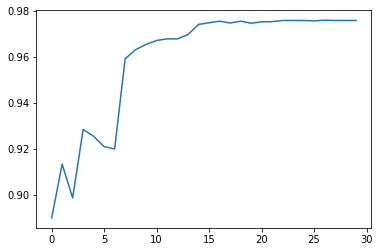

In [77]:
plt.plot(range(30), stats_lr['acc'], '-')

In [78]:
stats_lr.tail()

,acc,loss
25,0.9757,0.097923
26,0.9760,0.097853
27,0.9759,0.097783
28,0.9759,0.097777
29,0.9759,0.097770


Pretty cool, we can get up to 97.5% accuracy using just a plain logistic regression!! this is not a very hard NN problem it seems...

## 1  hidden layer

In [82]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(d_in, 200),
    #nn.Dropout(0.1),
    nn.LeakyReLU(),
    #nn.BatchNorm1d(200),
    nn.Linear(200, 10)
)

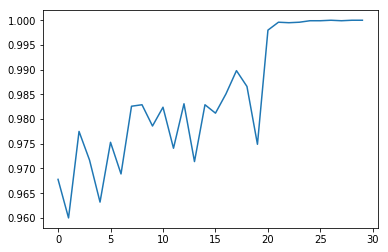

In [85]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lrs = StepLR(optimizer, step_size=20, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 30
stats_lr = train(model, optimizer, criterion, epochs, lrs)  
plt.plot(range(30), stats_lr['acc'], '-')

In [87]:
stats_lr.tail()

,acc,loss
25,0.9999,0.000499
26,1.0000,0.000090
27,0.9999,0.000118
28,1.0000,0.000051
29,1.0000,0.000025


100.00% accuracy is not bad .... clearly this problem is just too simple...

In [88]:
datasets.FashionMNIST

torchvision.datasets.mnist.FashionMNIST

## Fashion MNIST

In [90]:
ds_train = datasets.FashionMNIST('../data/fashionmnist', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
train_loader = torch.utils.data.DataLoader(ds_train,batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data/fashionmnist', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=32, shuffle=True)

Processing...
Done!


In [91]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(d_in, 200),
    #nn.Dropout(0.1),
    nn.LeakyReLU(),
    #nn.BatchNorm1d(200),
    nn.Linear(200, 10)
)

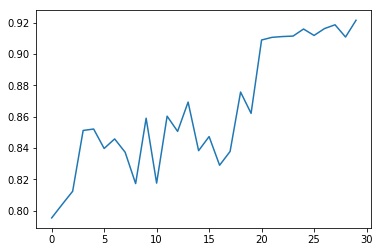

In [92]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lrs = StepLR(optimizer, step_size=20, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 30
stats_lr = train(model, optimizer, criterion, epochs, lrs)  
plt.plot(range(30), stats_lr['acc'], '-')

In [93]:
stats_lr.tail()

,acc,loss
25,0.9118,0.228533
26,0.9162,0.222623
27,0.9186,0.211974
28,0.9108,0.233630
29,0.9215,0.206500


## Investigate effect of batchnorm

In [95]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(d_in, 200),
    #nn.Dropout(0.1),
    nn.LeakyReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10)
)

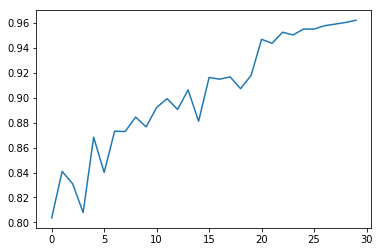

In [96]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lrs = StepLR(optimizer, step_size=20, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 30
stats_lr = train(model, optimizer, criterion, epochs, lrs)  
plt.plot(range(30), stats_lr['acc'], '-')

In [97]:
stats_lr.tail()

,acc,loss
25,0.9551,0.124318
26,0.9578,0.122056
27,0.9591,0.119570
28,0.9604,0.115545
29,0.9622,0.110927


NICE!!! batch norm boosts val accuracy to 0.96

## Investigate effect of dropout

In [113]:
drops = []
accs = []
for dropout in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print(f"training for dropout {dropout}")
    model = nn.Sequential(
        Flatten(),
        nn.Linear(d_in, 400),
        nn.Dropout(dropout),
        nn.LeakyReLU(),
        nn.BatchNorm1d(400),
        nn.Linear(400, 10)
    )
    model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    lrs = StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()
    epochs = 20
    stats_lr = train(model, optimizer, criterion, epochs, lrs)  
    acc = stats_lr.iloc[-1].acc
    drops.append(dropout)
    accs.append(acc)
df_dropout = pd.DataFrame({'dropout': drops, 'acc': accs})

training for dropout 0
training for dropout 0.1
training for dropout 0.2
training for dropout 0.3
training for dropout 0.4
training for dropout 0.5


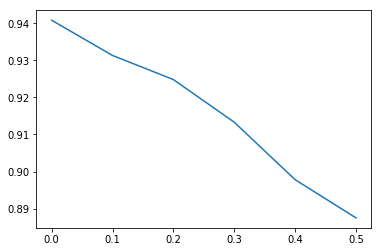

In [114]:
plt.plot(df_dropout['dropout'], df_dropout['acc'])

In [115]:
df_dropout

,acc,dropout
0,0.9408,0.0
1,0.9313,0.1
2,0.9248,0.2
3,0.9133,0.3
4,0.8978,0.4
5,0.8875,0.5


Dropout definitely seems to make things a lot worse here... interesting. Lets try train a convnet and see what happens!

## Convnet

In [154]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

In [155]:
model = nn.Sequential(
        # conv block 1
        nn.Conv2d(1, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2, 2),
        
        # conf block 2
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
    
        # conf block 3
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2),
        
        # 1x1 convolution
        nn.Conv2d(64, 10, kernel_size=1),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.AdaptiveAvgPool2d((1,1)),
        
        # fc layers
        Flatten()
    )

In [156]:
xtest = next(iter(train_loader))[0]

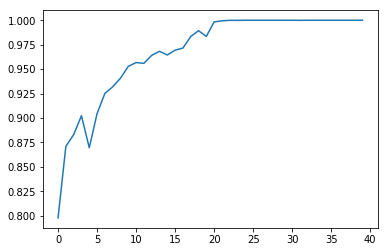

In [157]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lrs = StepLR(optimizer, step_size=20, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 40
stats_lr = train(model, optimizer, criterion, epochs, lrs)  
plt.plot(range(40), stats_lr['acc'], '-')

In [158]:
stats_lr.tail()

,acc,loss
35,1.0,0.000917
36,1.0,0.000765
37,1.0,0.000976
38,1.0,0.000711
39,1.0,0.000640


Pretty much piece of cake when using an CNN... I like this fully convolutional architecture =)